In [ ]:
import os
import cv2
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Dataset
from google.colab import drive
torch.manual_seed(777)
drive.mount('/content/drive')

Mounted at /content/drive


#preprocess

In [ ]:
!ls
os.chdir('/content/drive/Shareddrives/2022_ICPS/2022_수어')

drive  sample_data


##use json(fail)

In [ ]:
f = open('/content/drive/MyDrive/out.ply', 'r')
pixels = []
depth = []
red = []
green = []
blue = []
for line in f: 
    pixel = line[:len(line)-1].split(' ')
    depth.append(int(pixel[0]))
    red.append(int(pixel[1]))
    green.append(int(pixel[2]))
    blue.append(int(pixel[3]))

red = torch.tensor(red).resize(1920, 1080)
blue = torch.tensor(blue).resize(1920, 1080)
green = torch.tensor(green).resize(1920, 1080)
depth = torch.tensor(depth).resize(1920, 1080)

print(pixels)


In [ ]:
import json

with open('/content/drive/MyDrive/1L01.json', 'r') as f:
    content =  json.load(f)

joint_point = [x for x in content['frames']]
print(joint_point)
keys = joint_point[0].keys()
print(keys)

point = []
for frame in joint_point:
    frame_data = frame['bodies'][0]['joint_positions_2D']
    point.append(frame_data)

In [ ]:
video_file = './1/L/I-01-0002-L.mkv'
cap = cv.VideoCapture(video_file)
length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv.CAP_PROP_FPS))

mid_point_x = 930
mid_point_y = 600
idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    color = 50
    for po in point[idx]:
        crop_point = (int(po[0]), int(po[1]))
        #print(crop_point)
        st_x = crop_point[0] - 100 
        ed_x = crop_point[0] + 100
        st_y = crop_point[1] - 250
        ed_y = crop_point[1]
        if color == 100:
            frame = cv.line(frame, crop_point, crop_point, (255, 0, 255), 20)
        else:
            frame = cv.line(frame, crop_point, crop_point, (0, 100, 0), 20)
        color = color + 50
    
    # crop_point = (int(mid_point_x + point[idx][0]), int(mid_point_y + point[idx][1]))
    # print(crop_point)
    # st_x = crop_point[0] - 100 
    # ed_x = crop_point[0] + 100
    # st_y = crop_point[1] - 100
    # ed_y = crop_point[1] + 100
    # frame = cv.line(frame, crop_point, crop_point, (0, 0, 0), 20)
    #frame = cv.line(frame, (st_x, st_y), (ed_x,  ed_y), (0, 255, 0), 20)
    #frame = frame[st_y:ed_y,st_x:ed_x]
    
    plt.imshow(frame)
    plt.show()
    idx = idx + 1
    if idx > len(point): break

##Use mediapipe

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████▌            | 19.2 MB 28.4 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
home_path = '/content/drive/Shareddrives/2022_ICPS/2022 수어/'
video_file_list_home = [str(x) for x in range(38, 41, 1)] # 1-23완
print(video_file_list_home)
sub_list = ['L', 'R']
save_path = '/content/drive/Shareddrives/ICPS_Challenge_Data/'

key_point = (0, 5, 9, 13, 17)
Target = {"L": "Right", "R": "Left"}

['38', '39', '40']


In [ ]:
import mediapipe as mp
for label in video_file_list_home:
    for filename in sub_list:
        video_list = os.listdir(home_path + label +'/'+filename)
        print(video_list)
        for path in video_list:
            video_file_path  = home_path + label + '/' + filename + '/' + path
            #print(video_file_path)
            cap = cv2.VideoCapture(video_file_path)

            mp_hands = mp.solutions.hands
            hands = mp_hands.Hands(max_num_hands=2)
            mp_draw = mp.solutions.drawing_utils

            fps = 0
            while True:
                ret, img = cap.read()
                if not ret:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = hands.process(img)
                #print(results.multi_hand_landmarks)
                fps += 1
                if results.multi_hand_landmarks:
                    point_list = []
                    check = 0
                    if len(results.multi_handedness) == 2:
                        for classification in results.multi_handedness:
                            if str(classification)[str(classification).find("label: \"")+8:-4] == Target[filename]:
                                break
                            else:
                                check +=1
                        del classification
                    for handLms in results.multi_hand_landmarks:
                        for id, lm in enumerate(handLms.landmark):
                            h, w, c = img.shape
                            cx, cy = int(lm.x*w), int(lm.y*h)
                            #print(h, w)
                            point_list.append([cx, cy])
                        #mp_draw.draw_landmarks(img, handLms, mp_hands.HAND_CONNECTIONS)
                    
                    #crop image
                    #print(point_list)
                    sum = torch.zeros(2)
                    if check == 1: check = int(len(point_list)/2)   
                    #print(len(point_list), point_list)
                    for point in key_point:
                        sum = sum + torch.tensor(point_list[point+check])
                    sum = (sum/len(key_point)).int()
                    #print(sum)
                    
                    #print(point_list)
                    max_x = min_x = point_list[check][0]
                    max_y = min_y = point_list[check][1]
                    if check == int(len(point_list)/2):
                        for point in point_list[check:]:
                            if max_x < point[0]: max_x = point[0]
                            elif min_x > point[0]: min_x = point[0]

                            if max_y < point[1]: max_y = point[1]
                            elif min_y > point[1]: min_y = point[1]
                    elif check == 0 and len(point_list) > 21:
                        for point in point_list[:21]:
                            if max_x < point[0]: max_x = point[0]
                            elif min_x > point[0]: min_x = point[0]

                            if max_y < point[1]: max_y = point[1]
                            elif min_y > point[1]: min_y = point[1]
                    else:
                        for point in point_list:
                            if max_x < point[0]: max_x = point[0]
                            elif min_x > point[0]: min_x = point[0]

                            if max_y < point[1]: max_y = point[1]
                            elif min_y > point[1]: min_y = point[1]

                #print(max_x, min_x, max_y, min_y)
                x_len = int((max_x - min_x))
                y_len = int((max_y - min_y))
                crop_len = int((x_len if x_len > y_len else y_len)/1.2)
                #print(x_len, y_len, crop_len)
                #print(sum[0], sum[1])
                img = img[sum[1]-crop_len:sum[1]+crop_len, sum[0]-crop_len:sum[0]+crop_len]
                if img.size > 10 * 10 * 3:
                    img = cv2.resize(img, (300, 300))
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(save_path+label+'/'+path[:-4]+'_'+str(fps)+'.jpg', img)
                else:
                    print("skip frame ", fps)
                #print(fps)
  
                # plt.imshow(img)
                # plt.show()
                    #save image
            
            cap.release()
            print(path, " done", fps)
            del cap, mp_hands, hands, mp_draw, fps, img, results, point_list, check, sum
            

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c97c8fe9acce>", line 1, in <module>
    import mediapipe as mp
ModuleNotFoundError: No module named 'mediapipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 319, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 353, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python3.7/inspect.py", line 1502, in getinnerframes
    fra

ModuleNotFoundError: ignored

###omission check

In [ ]:
import mediapipe as mp
video_file_path  = '/content/drive/Shareddrives/2022_ICPS/2022 수어/33/R/I-33-0017-R.mkv'
save_path = '/content/drive/Shareddrives/ICPS_Challenge_Data/33/I-33-0017-R'

#print(video_file_path)
cap = cv2.VideoCapture(video_file_path)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

fps = 0
while True:
    ret, img = cap.read()
    if not ret:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img)
    #print(results.multi_hand_landmarks)
    fps += 1
    if results.multi_hand_landmarks:
        point_list = []
        check = 0
        if len(results.multi_handedness) == 2:
            for classification in results.multi_handedness:
                if str(classification)[str(classification).find("label: \"")+8:-4] == Target['R']:
                    break
                else:
                    check +=1
            del classification
        for handLms in results.multi_hand_landmarks:
            for id, lm in enumerate(handLms.landmark):
                h, w, c = img.shape
                cx, cy = int(lm.x*w), int(lm.y*h)
                #print(h, w)
                point_list.append([cx, cy])
            #mp_draw.draw_landmarks(img, handLms, mp_hands.HAND_CONNECTIONS)

        #crop image
        #print(point_list)
        sum = torch.zeros(2)
        if check == 1: check = int(len(point_list)/2)
        #print(len(point_list), point_list)
        for point in key_point:
            sum = sum + torch.tensor(point_list[point+check])
        sum = (sum/len(key_point)).int()
        #print(sum)
        
        #print(point_list)
        max_x = min_x = point_list[check][0]
        max_y = min_y = point_list[check][1]
        for point in point_list:
            if max_x < point[0]: max_x = point[0]
            elif min_x > point[0]: min_x = point[0]

            if max_y < point[1]: max_y = point[1]
            elif min_y > point[1]: min_y = point[1]

    #print(max_x, min_x, max_y, min_y)
    x_len = int((max_x - min_x))
    y_len = int((max_y - min_y))
    crop_len = int((x_len if x_len > y_len else y_len)/1.2)
    #print(x_len, y_len, crop_len)
    #print(sum[0], sum[1])
    img = img[sum[1]-crop_len:sum[1]+crop_len, sum[0]-crop_len:sum[0]+crop_len]
    if img.size > 10 * 10 * 3:
        img = cv2.resize(img, (300, 300))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path+'_'+str(fps)+'.jpg', img)
        print("done frame ", fps)
    else:
        print("skip frame ", fps)

cap.release()
#print(path, " done")

###Test

In [ ]:
import cv2 as cv
video_file = './1/L/I-01-0002-L.mkv'
cap = cv.VideoCapture(video_file)
length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv.CAP_PROP_FPS))

print(length, width, height, fps)

mid_point_x = 540
mid_point_y = 960
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # frame = frame[284:796, 734:1246]
   
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    #print(frame)
    # # Lower = np.array([0, 80, 90], dtype="uint8")
    # # Upper = np.array([10, 90, 255], dtype="uint8")
    # # skin_mask = cv.inRange(frame, Lower, Upper)


    # # skin_mask = cv.dilate(skin_mask, (11,11), iterations = 3)
    # # skin_mask = cv.GaussianBlur(skin_mask, (3, 3), 0)
    # # line,_ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # # cv.drawContours(frame, line, -1, (0, 255, 0), 4)
    # # frame = cv.cvtColor(frame, cv.COLOR_HSV2RGB)
    plt.imshow(frame)
    plt.show()


    # frame = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)
    # mask_hand = cv.inRange(frame, np.array([30, 143, 77]), np.array([255, 173, 127]))
    # mask = cv.bitwise_and(frame, frame, mask = mask_hand)
    # mask = cv.cvtColor(mask, cv.COLOR_YCrCb2RGB)
    # plt.imshow(mask)
    # plt.imshow(frame)
    plt.show()
    break
    
cap.release()

# model 

## DataLoad

In [ ]:
if torch.cuda.is_available():
   device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

cuda


In [ ]:
class MyDataset(Dataset):
    def __init__(self, path):
        self.path = path
        classes = os.listdir(self.path)
        print(classes)
        cmap = {v:i for i, v in enumerate(classes)}
        self.x = []
        self.y = []
        for label in tqdm(classes):
            for data in os.listdir(self.path+'/'+label):
                x = cv2.imread(self.path+'/'+label+'/'+data).astype(np.uint8)
                x = cv2.resize(x,(64, 64)).transpose((2, 0, 1))
                self.x.append(x)
                del x 
                self.y.append(cmap[label])
        del cmap, classes

    def __len__(self):
        print(len(self.x), len(self.y))
        return len(self.x)
        
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x[idx])/255
        y = self.y[idx]
        return x, y

In [ ]:
dataPath = '/content/drive/Shareddrives/ICPS_Challenge_Data'
dataList = os.listdir(dataPath)
print(dataList)

myData = MyDataset(dataPath)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']


100%|██████████| 40/40 [1:36:01<00:00, 144.03s/it]


In [ ]:
len(myData)
val_size = 14500
test_size = 31000
train_size = len(myData) - val_size - test_size

train, val, test = random_split(myData, [train_size, val_size, test_size])
print(len(train), len(val), len(test)) 

318391 318391
318391 318391
318391 318391
272891 14500 31000


In [ ]:
batch_size = 256
train_dl = DataLoader(train, batch_size , num_workers=2, shuffle=True)
val_dl = DataLoader(val, batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size)

torch.Size([256, 3, 64, 64])
tensor([ 2, 25,  2, 35,  2, 26, 10, 29, 39,  5, 24, 20, 16, 38, 34, 29, 12, 23,
        25, 34, 17, 27, 27, 39, 25, 17,  1, 31, 31, 12, 37, 39, 26, 26, 31,  3,
         7, 29, 11, 15, 36,  8, 40, 27, 25, 16,  2,  9,  3,  5, 38, 19, 37, 24,
        33, 10, 27, 17, 40,  6,  6, 39, 18, 36, 19, 17, 14, 40, 16,  7,  2, 15,
         5, 30, 14, 24, 22, 22,  1, 16, 16, 40, 32, 31, 36, 30, 33,  5, 37, 25,
        16, 19, 17, 14,  4, 17,  9, 27, 12,  7, 13, 29, 39, 34, 37,  7,  3, 26,
        22, 21, 24, 36, 16, 28,  5, 10,  4, 29, 12, 18, 31, 33,  8,  1, 20, 30,
        21,  7, 28, 27,  4, 29, 38,  6, 36, 39, 21,  9, 20, 33, 29, 28,  8, 19,
        22, 23, 13,  8,  5, 20, 18, 13, 40, 24, 22, 34, 10, 15, 32, 20,  2, 30,
        32, 25, 39, 36,  3,  6, 33, 32, 11, 22, 14, 16, 38,  3, 28, 22, 12, 28,
        34, 35,  3, 31, 34,  6, 34,  3, 11, 33,  5,  6,  3, 20,  1, 28, 21, 13,
        26, 31, 30,  6, 21, 21, 32, 24, 17,  9, 37, 16, 11,  6, 23, 30,  9, 31,
        11,

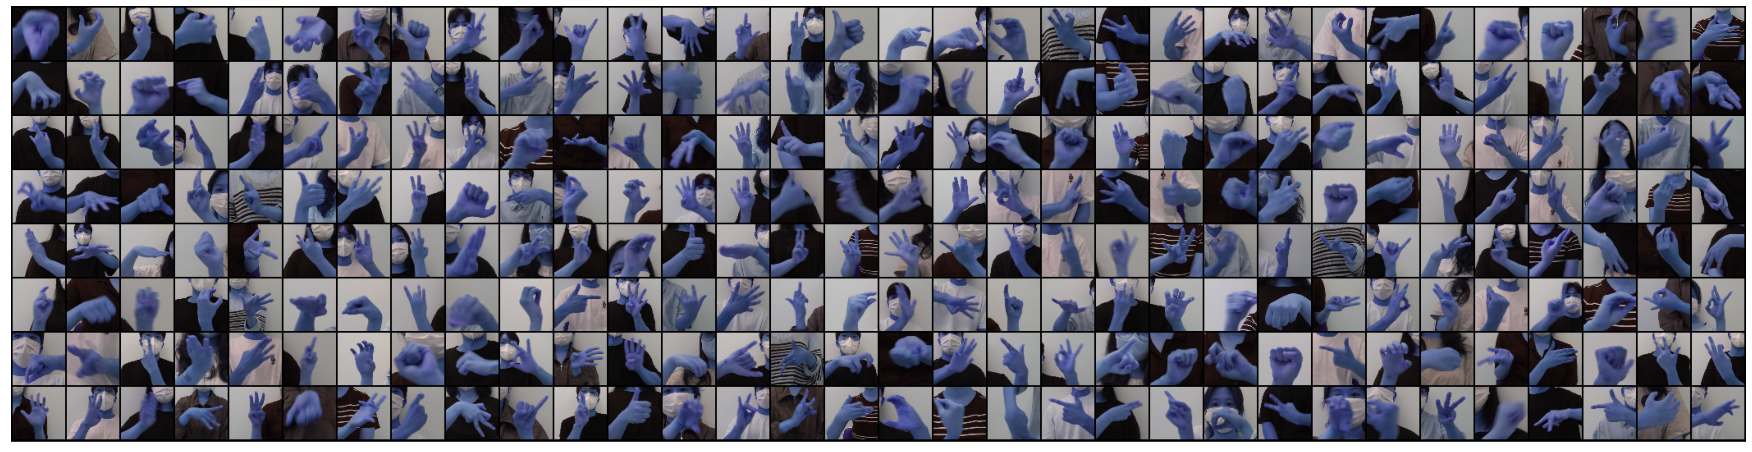

In [ ]:
images, labels = next(iter(train_dl))
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(32, 8))
        ax.set_xticks([]) ; ax.set_yticks([])
        print(images.shape)
        print(labels+1)
        ax.imshow(make_grid((images.to('cpu')), nrow=32).permute(1, 2, 0))
        break

show_batch(train_dl)

## Training

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channel, out_channel, pool=False):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1), nn.ReLU(True)]
    if pool:
        layers.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*layers)

class ImageClassfication(nn.Module):
    def train_step(self, batch):
        images, classes = batch
        out = self(images)          #Generate prediction
        loss = F.cross_entropy(out, classes)   #Calculate loss
        return loss

    def validation_step(self, batch):
        images, classes = batch
        out = self(images)                  
        loss = F.cross_entropy(out, classes)
        acc = accuracy(out, classes)            #Calculate Accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class VGG19(ImageClassfication):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64, True),   #64x64x64

            conv_block(64, 128),
            conv_block(128, 128, True), #128x32x32

            conv_block(128, 256),
            conv_block(256, 256),
            conv_block(256, 256),
            conv_block(256, 256, True), #256x16x16

            conv_block(256, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x8x8

            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512, True), #512x4x4

            #classifier
            nn.Sequential(
                nn.Flatten(), 
                nn.Linear(512 * 2 * 2, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, num_classes)
                )
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, xb):
         return self.network(xb)

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, lr, model, train_loader, val_loader,load=False,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    if load:
        checkpoint = torch.load('./kinect.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        count = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        #Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './kinect.pth')
    
    del loss, result, train_losses
    torch.cuda.empty_cache()
    return history

In [ ]:
!ls
os.chdir('/content/drive/MyDrive')

drive  sample_data


In [ ]:
lr = 0.01
model = VGG19(40)
model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
print(model)

VGG19(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplac

In [ ]:
# 20 epochs
epochs = 10
VGG19_history = training(epochs, lr, model, train_dl, val_dl, load=True)
torch.save(model,'./kinect_vgg19.pth')

100%|██████████| 1066/1066 [06:18<00:00,  2.81it/s]


Epoch [0], val_loss: 0.1920, val_acc: 0.9494


100%|██████████| 1066/1066 [06:14<00:00,  2.85it/s]


Epoch [1], val_loss: 0.1405, val_acc: 0.9622


100%|██████████| 1066/1066 [06:14<00:00,  2.85it/s]


Epoch [2], val_loss: 0.1397, val_acc: 0.9649


100%|██████████| 1066/1066 [06:13<00:00,  2.85it/s]


Epoch [3], val_loss: 0.1438, val_acc: 0.9629


100%|██████████| 1066/1066 [06:13<00:00,  2.85it/s]


Epoch [4], val_loss: 0.1305, val_acc: 0.9664


100%|██████████| 1066/1066 [06:13<00:00,  2.85it/s]


Epoch [5], val_loss: 0.1382, val_acc: 0.9676


100%|██████████| 1066/1066 [06:13<00:00,  2.85it/s]


Epoch [6], val_loss: 0.1377, val_acc: 0.9673


 54%|█████▍    | 576/1066 [03:21<02:51,  2.85it/s]

### Diagram(not doing)

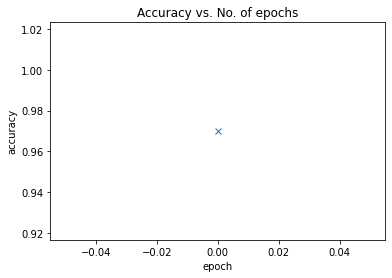

In [ ]:
acc = [x['val_acc'] for x in VGG19_history]
plt.plot(acc, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

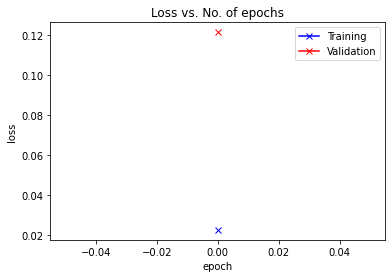

In [ ]:
train_loss = [x['train_loss'] for x in VGG19_history]
val_loss = [x['val_loss'] for x in VGG19_history]
plt.plot(train_loss, '-bx')
plt.plot(val_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Test

In [ ]:
test_model = torch.load('./kinect_vgg19.pth')
test_model.to(device)
test_dl = DeviceDataLoader(test_dl, device)

yes = 0
no = 0
for images, labels in tqdm(test_dl):
    out = test_model(images)
    _, pred = torch.max(out, dim=1)
    for i in range(len(pred)):
        if  pred[i] == labels[i]:
            #plt.imshow(np.totorch(images[i]))
            #plt.show()
            yes = yes + 1
        else:
            no = no +1

total = yes + no
correct_percent = yes/total * 100
print("\ntesting result:", correct_percent, "%")

100%|██████████| 122/122 [00:22<00:00,  5.43it/s]


testing result: 95.19032258064516 %


## Pytorch to keras(not doing)


In [ ]:
!pip install onnx
!pip install onnx2keras
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24593 sha256=01ad985a94c8a27538386885a57980980a845d60564f165398ab938f44e106fd
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built onnx2keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 7.2 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 


### pytorch to onnx

In [ ]:
dummy_input = torch.randn(batch_size, 3, 64, 64, requires_grad = True, device = 'cuda')
model = torch.load('./kinect_vgg19.pth')
torch_out = model(dummy_input)
torch.onnx.export(model, dummy_input, "icpsChallenge.onnx", export_params=True, opset_version=10, do_constant_folding=True,
                  input_names=['input'], output_names=['output'], dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

In [ ]:
import onnx
onnx_model = onnx.load("./icpsChallenge.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime as rt
ort_session = rt.InferenceSession("./icpsChallenge.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outputs = ort_session.run(None, ort_inputs)
np.testing.assert_allclose(to_numpy(torch_out), ort_outputs[0], rtol=1e-03, atol=1e-05)

AssertionError: ignored

### onnx to keras

In [ ]:
from onnx2keras import onnx_to_keras
k_model = onnx_to_keras(onnx_model, ["input"])

ValueError: ignored